In [1]:
import mysql.connector as con

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# convert data from SQL to Pandas DataFrame

In [2]:
fd = open('SQLData/claims_v1_live.sql', 'r')
sqlFile = fd.readlines()
fd.close()

In [3]:

commands = []
statement = ""

for line in tqdm(sqlFile):

    line = line.replace('\n','')
    
    if re.search(r'--', line):  # ignore sql comment lines
        continue
       
    if re.search(r'/*!',line):
        continue
    
    if not re.search(r';$', line):  # keep appending lines that don't end in ';'
        statement = statement + line
        
    else:  # when you get a line ending in ';' then exec statement and reset for next statement
        statement = statement + line
        commands.append(statement)

        statement = ""



100%|██████████| 1026688/1026688 [00:07<00:00, 131825.72it/s]


In [10]:
print(commands[5])

INSERT INTO `cares` (`id`, `name`, `base_name`, `type`, `active`, `created_at`, `updated_at`, `nlp_result`, `type_id`, `meta`, `drug_generic_id`, `parent_id`, `cve_version`) VALUES(729, 'DOCITAXEL 80MG INJ - 1 VIAL', NULL, NULL, 1, '2018-02-14 12:32:17', '2018-02-14 12:32:17', NULL, NULL, NULL, NULL, NULL, NULL),(730, 'DOPAMINE INJ 40MG - 1 AMPOULE', NULL, NULL, 1, '2018-02-14 12:32:17', '2018-02-14 12:32:17', NULL, NULL, NULL, NULL, NULL, NULL),(731, 'DRUJELA GEL 10G - 1 TUBE', NULL, NULL, 1, '2018-02-14 12:32:17', '2018-02-14 12:32:17', NULL, NULL, NULL, NULL, NULL, NULL),(732, 'DUCOLAX SUPPOSITORY - 1 SUPPO', NULL, NULL, 1, '2018-02-14 12:32:17', '2018-02-14 12:32:17', NULL, NULL, NULL, NULL, NULL, NULL),(733, 'DUOVIR 650MG TAB - 1 TABLET', NULL, NULL, 1, '2018-02-14 12:32:17', '2018-02-14 12:32:17', NULL, NULL, NULL, NULL, NULL, NULL),(734, 'DUPHASTON TABLET 10MG - 1 TABLET', NULL, NULL, 1, '2018-02-14 12:32:17', '2018-02-14 12:32:17', NULL, NULL, NULL, NULL, NULL, NULL),(735, 'DYN

In [4]:
len(commands)

2430

In [5]:
cur = con.connect(host='localhost',database='mysql',user='root',password='52dna52myaim')

In [6]:
cursor =cur.cursor()

In [8]:

skip = []

cursor.execute("drop table cares;")
cursor.execute("drop table care_types;")
cursor.execute("drop table claims;")
for command in tqdm(commands):

    try:
        cursor.execute(command)
    except:
        skip.append(command)


100%|██████████| 2430/2430 [00:20<00:00, 120.98it/s]


In [9]:
len(skip)

1853

In [25]:
table_names = ['cares', 'care_types', 'claim_comments', 'claim_diagnoses', 'claim_items', 'claims','comments',\
          'diagnoses', 'provider_tariffs']
          

In [24]:
tables = {}
table_columns = {}

In [26]:
for t in table_names:
    print(t)
    fetchdata = "select * from " + t + ";"
    cursor.execute(fetchdata)
    tables[t] = cursor.fetchall()
    
    fetchcolumn = "show columns from " + t + ";"
    cursor.execute(fetchcolumn)
    table_columns[t] = cursor.fetchall()

cares
care_types
claim_comments
claim_diagnoses
claim_items
claims
comments
diagnoses
provider_tariffs


In [27]:
for k in tables:
    print(k)

cares
care_types
claim_comments
claim_diagnoses
claim_items
claims
comments
diagnoses
provider_tariffs


In [30]:
total = 0
for k in tables:
    print(k,' : ',len(tables[k]))
    total += len(tables[k])
total

cares  :  83124
care_types  :  15
claim_comments  :  402
claim_diagnoses  :  112119
claim_items  :  323149
claims  :  62451
comments  :  3109
diagnoses  :  104272
provider_tariffs  :  335181


1023822

In [32]:
# converts results to dataframe
# all tables into a dictionary
all_df = {}

for k in tqdm(tables):
    # initiate dataframe
    print(k) # print table name
    data = {}
   
    # initiate dictionary for each table
    columns = []
    for name in table_columns[k]:
        data[name[0]] = [] # initiate data
        columns.append(name[0]) # get column name
        
    for row in range(len(tables[k])):
        temp = tables[k][row] # fetch data
        for col in range(len(columns)): 
            data[columns[col]].append(temp[col]) # allocate data to each column for each row
         
    all_df[k] = pd.DataFrame(data) # convert dictionary of table to dataframe



  0%|          | 0/9 [00:00<?, ?it/s]

cares


 11%|█         | 1/9 [00:00<00:03,  2.20it/s]

care_types
claim_comments
claim_diagnoses


 44%|████▍     | 4/9 [00:00<00:01,  2.94it/s]

claim_items


 56%|█████▌    | 5/9 [00:02<00:03,  1.16it/s]

claims


 67%|██████▋   | 6/9 [00:03<00:02,  1.23it/s]

comments
diagnoses


 89%|████████▉ | 8/9 [00:03<00:00,  1.57it/s]

provider_tariffs


100%|██████████| 9/9 [00:05<00:00,  1.61it/s]


In [35]:
# save dataframe to csv
for table in all_df:
    filename = 'Data/'+ table + '.csv'
    all_df[table].to_csv(filename)

# explore data

In [39]:
for table in all_df:
    print(table)
    display(all_df[table].head(5))
    print('\n')

cares


,id,name,base_name,type,active,created_at,updated_at,nlp_result,type_id,meta,drug_generic_id,parent_id,cve_version
0,2,Chest X-ray,None,INVESTIGATION,1,2019-04-23 15:27:50,2019-09-26 18:40:31,None,NaN,None,NaN,None,NaN
1,6,Gentamycin,None,DRUG,1,2019-04-23 15:27:50,2019-10-05 18:14:30,None,1.0,None,927.0,None,NaN
2,7,Amikacin,None,DRUG,1,2019-04-23 15:27:50,2019-10-06 01:58:26,None,1.0,None,178.0,None,NaN
3,8,Metronidazole 500mg,None,DRUG,1,2019-04-23 15:27:50,2019-04-23 15:27:50,None,NaN,None,NaN,None,NaN
4,9,Consultation,None,None,1,2019-04-23 15:27:50,2019-04-23 15:27:50,None,NaN,None,NaN,None,NaN




care_types


,id,name,meta,cve_version
0,1,MEDICATION,"[""STRENGTH"",""FORM"",""DOSAGE"",""ROUTE_OR_MODE"",""T...",NaN
1,2,INVESTIGATION,None,2.0
2,3,CONSULTATION,None,2.0
3,4,PROCEDURE,None,2.0
4,6,MISCELLANEOUS,None,NaN




claim_comments


,id,claim_id,user_id,message,created_at,updated_at
0,1,33,9,capitated bill,2018-05-21 10:25:20,2018-05-21 10:25:20
1,2,58,5,vetted yet?,2018-10-18 18:51:36,2018-10-18 18:51:36
2,3,2682,24,"INCOMPLETE CLAIMS. PLEASE, DO NOT PROCESS THIS...",2018-11-09 15:00:30,2018-11-09 15:00:30
3,4,3781,21,PCM 18 TAB ADMINISTERED & FOLIC ACID 14 TAB AD...,2018-11-19 10:50:59,2018-11-19 10:50:59
4,5,3893,21,"AUGMENTIN 10 TAB, IBUPROFEN 15TAB, LISINOPRIL ...",2018-11-21 11:31:30,2018-11-21 11:31:30




claim_diagnoses


,id,claim_id,diagnosis_id
0,15,10,9
1,16,11,15925
2,36,13,4342
3,37,14,15925
4,38,15,6190




claim_items


,id,claim_id,care_id,amount,created_at,hmo_approved,updated_at,qty,approved_amount,approved_qty,comment_id,drug_frequency,drug_duration,drug_duration_sub,tariff_id
0,16,10,586,1816.08,2018-03-12 14:53:46,1,2018-05-21 10:05:30,6,1816.08,6,NaN,NaN,NaN,NaN,NaN
1,17,11,586,1816.08,2018-03-13 14:50:39,1,2018-05-21 10:07:19,6,1816.08,6,NaN,NaN,NaN,NaN,NaN
2,56,13,434,115.00,2018-03-16 10:28:53,1,2018-05-21 10:09:30,5,115.00,5,NaN,NaN,NaN,NaN,NaN
3,57,13,1102,1265.00,2018-03-16 10:28:53,1,2018-05-21 10:09:30,10,1265.00,10,NaN,NaN,NaN,NaN,NaN
4,58,13,299,138.00,2018-03-16 10:28:53,1,2018-05-21 10:09:30,15,138.00,15,NaN,NaN,NaN,NaN,NaN




claims


,id,hmo_id,hmo_pile_id,provider_id,enrollee_id,enrollee_info,admission_start,admission_end,approval_code,encounter_date,...,provider_approved_by,hmo_status,created_at,updated_at,hmo_skipped,log,synced_at,vetted_at,child_hmo_id,meta
0,10,1,1.0,1,89,None,None,None,None,2018-03-02,...,0.0,1,2018-03-12 14:53:46,2018-05-21 10:05:30,0,None,2018-11-27 12:11:53,2018-05-21 10:05:30,None,None
1,11,1,1.0,1,89,None,None,None,None,2018-03-02,...,5.0,1,2018-03-13 14:50:39,2018-05-21 10:07:19,0,None,2018-11-27 12:11:53,2018-05-21 10:07:19,None,None
2,13,1,1.0,1,74,None,None,None,None,2018-03-10,...,0.0,1,2018-03-16 10:28:53,2018-05-21 10:09:30,0,None,2018-11-27 12:11:53,2018-05-21 10:09:30,None,None
3,14,1,1.0,1,89,None,None,None,None,2018-03-02,...,0.0,1,2018-03-16 10:34:41,2018-05-21 10:09:56,0,None,2018-11-27 12:11:53,2018-05-21 10:09:56,None,None
4,15,1,1.0,1,183,None,None,None,RC/03/2PRO01AM,2018-03-11,...,0.0,1,2018-03-16 10:49:57,2018-05-21 10:15:05,0,None,2018-11-27 12:11:53,2018-05-21 10:15:05,None,None




comments


,id,name
0,1684,\tNVESTIGATION NOT NEEDED
1,1209,Kindly Provide approval for DHeas
2,1171,clearly state the required investigation
3,3227,diff in cost of consumables
4,871,Diff in investigation cost.




diagnoses


,id,icd_order,icd_code,icd_header,name,category_id,active,matching_enabled,nlp_meta
0,1,NaN,None,NaN,CHOLERA,1.0,1,NaN,None
1,2,NaN,None,NaN,TYPHOID/ ENTERIC FEVER,1.0,1,1.0,None
2,3,NaN,None,NaN,TUBERCULOSIS,1.0,1,NaN,None
3,4,NaN,None,NaN,STIs,1.0,1,NaN,None
4,5,NaN,None,NaN,UTIs,1.0,1,NaN,None




provider_tariffs


,id,hmo_id,provider_id,care_id,amount,amount_range,created_at,updated_at,meta,desc,desc_synonym
0,1,1,1,11,1000.00,None,2018-02-08 13:00:23,2018-02-08 13:00:23,None,None,None
1,2,1,1,12,500.00,None,2018-02-08 13:00:23,2018-02-08 13:00:23,None,None,None
2,3,1,1,13,5000.00,None,2018-02-08 13:00:23,2018-02-08 13:00:23,None,None,None
3,4,1,1,14,2500.00,None,2018-02-08 13:00:23,2018-02-08 13:00:23,None,None,None
4,5,1,1,15,1000.00,None,2018-02-08 13:00:23,2018-02-08 13:00:23,None,None,None


In [40]:
for table in all_df:
    print(table)
    display(all_df[table].info())
    print('\n')

cares
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83124 entries, 0 to 83123
Data columns (total 13 columns):
id                 83124 non-null int64
name               83124 non-null object
base_name          4114 non-null object
type               39037 non-null object
active             83124 non-null int64
created_at         83124 non-null datetime64[ns]
updated_at         83120 non-null datetime64[ns]
nlp_result         0 non-null object
type_id            13849 non-null float64
meta               5919 non-null object
drug_generic_id    9493 non-null float64
parent_id          0 non-null object
cve_version        7088 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(6)
memory usage: 8.2+ MB


None



care_types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
id             15 non-null int64
name           15 non-null object
meta           1 non-null object
cve_version    6 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 608.0+ bytes


None



claim_comments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 6 columns):
id            402 non-null int64
claim_id      402 non-null int64
user_id       402 non-null int64
message       402 non-null object
created_at    402 non-null datetime64[ns]
updated_at    402 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 19.0+ KB


None



claim_diagnoses
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112119 entries, 0 to 112118
Data columns (total 3 columns):
id              112119 non-null int64
claim_id        112119 non-null int64
diagnosis_id    112119 non-null int64
dtypes: int64(3)
memory usage: 2.6 MB


None



claim_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323149 entries, 0 to 323148
Data columns (total 15 columns):
id                   323149 non-null int64
claim_id             323149 non-null int64
care_id              323149 non-null int64
amount               323149 non-null object
created_at           323149 non-null datetime64[ns]
hmo_approved         323149 non-null int64
updated_at           323149 non-null datetime64[ns]
qty                  323149 non-null int64
approved_amount      323149 non-null object
approved_qty         323149 non-null int64
comment_id           10800 non-null float64
drug_frequency       5933 non-null float64
drug_duration        5864 non-null float64
drug_duration_sub    5799 non-null float64
tariff_id            7380 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(6), object(2)
memory usage: 37.0+ MB


None



claims
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62451 entries, 0 to 62450
Data columns (total 24 columns):
id                      62451 non-null int64
hmo_id                  62451 non-null int64
hmo_pile_id             62167 non-null float64
provider_id             62451 non-null int64
enrollee_id             62451 non-null int64
enrollee_info           0 non-null object
admission_start         1903 non-null object
admission_end           1903 non-null object
approval_code           38311 non-null object
encounter_date          62451 non-null object
total_amount            62451 non-null object
approved_amount         62451 non-null object
created_by              62451 non-null int64
provider_status         62451 non-null int64
provider_approved_by    11667 non-null float64
hmo_status              62451 non-null int64
created_at              62451 non-null datetime64[ns]
updated_at              62451 non-null datetime64[ns]
hmo_skipped             62451 non-null int64
log 

None



comments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 2 columns):
id      3109 non-null int64
name    3109 non-null object
dtypes: int64(1), object(1)
memory usage: 48.7+ KB


None



diagnoses
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104272 entries, 0 to 104271
Data columns (total 9 columns):
id                  104272 non-null int64
icd_order           94743 non-null float64
icd_code            94782 non-null object
icd_header          94743 non-null float64
name                104272 non-null object
category_id         8192 non-null float64
active              104272 non-null int64
matching_enabled    29 non-null float64
nlp_meta            0 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 7.2+ MB


None



provider_tariffs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335181 entries, 0 to 335180
Data columns (total 11 columns):
id              335181 non-null int64
hmo_id          335181 non-null int64
provider_id     335181 non-null int64
care_id         335181 non-null int64
amount          334890 non-null object
amount_range    86 non-null object
created_at      335181 non-null datetime64[ns]
updated_at      335181 non-null datetime64[ns]
meta            6277 non-null object
desc            92913 non-null object
desc_synonym    19357 non-null object
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 28.1+ MB


None

In [126]:
all_df['cares'].loc[all_df['cares']['id']==6].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 13 columns):
id                 1 non-null int64
name               1 non-null object
base_name          0 non-null object
type               1 non-null object
active             1 non-null int64
created_at         1 non-null datetime64[ns]
updated_at         1 non-null datetime64[ns]
nlp_result         0 non-null object
type_id            1 non-null float64
meta               0 non-null object
drug_generic_id    1 non-null float64
parent_id          0 non-null object
cve_version        0 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(6)
memory usage: 112.0+ bytes


In [139]:
all_df['provider_tariffs'].loc[all_df['provider_tariffs']['care_id']==6].desc
all_df['claim_items'].loc[all_df['claim_items']['claim_id']==53350]

,id,claim_id,care_id,amount,created_at,hmo_approved,updated_at,qty,approved_amount,approved_qty,comment_id,drug_frequency,drug_duration,drug_duration_sub,tariff_id
272679,378828,53350,20641,45000.00,2019-11-05 17:49:49,0,2019-11-05 18:00:18,1,35000.00,1,NaN,NaN,NaN,NaN,360441.0
272680,378829,53350,64592,5000.00,2019-11-05 17:49:49,0,2019-11-05 17:49:49,1,5000.00,1,NaN,NaN,NaN,NaN,351178.0
272681,378830,53350,6,3000.00,2019-11-05 17:49:49,0,2019-11-05 17:49:49,1,3000.00,1,NaN,NaN,NaN,NaN,350603.0
272682,378831,53350,73145,6000.00,2019-11-05 17:49:49,0,2019-11-05 18:00:18,1,600.00,1,NaN,NaN,NaN,NaN,372686.0


In [190]:
df1 = all_df['claim_items'][['id','claim_id','care_id','amount','qty','approved_amount','approved_qty','hmo_approved']]

In [189]:
all_df['claims'].columns

Index(['id', 'hmo_id', 'hmo_pile_id', 'provider_id', 'enrollee_id',
       'enrollee_info', 'admission_start', 'admission_end', 'approval_code',
       'encounter_date', 'total_amount', 'approved_amount', 'created_by',
       'provider_status', 'provider_approved_by', 'hmo_status', 'created_at',
       'updated_at', 'hmo_skipped', 'log', 'synced_at', 'vetted_at',
       'child_hmo_id', 'meta'],
      dtype='object')

In [210]:
df2 = all_df['claims'][['id','hmo_id','provider_id','enrollee_id','approval_code',\
                      'provider_status','created_at','vetted_at']]

In [237]:
df3 = df1.merge(df2,how='outer',left_on='claim_id',right_on='id')
df3 = df3.drop(columns = ['id_x','id_y'])
df3 = df3[['claim_id','enrollee_id','provider_id','provider_status','hmo_id','care_id','qty','amount','approved_qty','approved_amount',\
         'hmo_approved','created_at','vetted_at']]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324203 entries, 0 to 324202
Data columns (total 13 columns):
claim_id           323149 non-null float64
enrollee_id        324194 non-null float64
provider_id        324194 non-null float64
provider_status    324194 non-null float64
hmo_id             324194 non-null float64
care_id            323149 non-null float64
qty                323149 non-null float64
amount             323149 non-null object
approved_qty       323149 non-null float64
approved_amount    323149 non-null object
hmo_approved       323149 non-null float64
created_at         324194 non-null datetime64[ns]
vetted_at          282385 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(9), object(2)
memory usage: 34.6+ MB


In [287]:
ct = all_df['claim_diagnoses'][['claim_id','diagnosis_id']].groupby('claim_id').count()
ct['diagnosis_id'].loc[ct['diagnosis_id']==16].count()

0

In [252]:
df3 = df3.sort_values(by=['claim_id'])
df3.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30


In [255]:
df5 = df3.merge(all_df['claim_diagnoses'][['claim_id','diagnosis_id']],how='left',left_on='claim_id',right_on='claim_id')

df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738882 entries, 0 to 738881
Data columns (total 14 columns):
claim_id           737828 non-null float64
enrollee_id        738855 non-null float64
provider_id        738855 non-null float64
provider_status    738855 non-null float64
hmo_id             738855 non-null float64
care_id            737828 non-null float64
qty                737828 non-null float64
amount             737828 non-null object
approved_qty       737828 non-null float64
approved_amount    737828 non-null object
hmo_approved       737828 non-null float64
created_at         738855 non-null datetime64[ns]
vetted_at          664671 non-null datetime64[ns]
diagnosis_id       737820 non-null float64
dtypes: datetime64[ns](2), float64(10), object(2)
memory usage: 84.6+ MB


In [225]:
comments1 = all_df['claim_items'][['claim_id','comment_id']].merge(all_df['claim_comments'][['id','message']],how='left',\
                                                     left_on='comment_id',right_on='id')
comments = comments1.drop(columns=['id']).merge(all_df['comments'][['id','name']],how='left',left_on='comment_id',right_on='id')
comments = comments.drop(columns=['id'])
comments.columns = ['claim_id','comment_id','message','additional_note']
comments.dropna().head()


,claim_id,comment_id,message,additional_note
106,49,377.0,Rejected Items are covered by capitation,Diff in procedure cost
5970,1183,18.0,LOSARTAN TAB 25MG ADMINISTERED,Capitation covers
18646,3781,2.0,vetted yet?,ok
52779,10364,35.0,RECURRENT PID,? INDICATION\r\r
56994,11177,35.0,RECURRENT PID,? INDICATION\r\r


In [290]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323149 entries, 0 to 323148
Data columns (total 4 columns):
claim_id           323149 non-null int64
comment_id         10800 non-null float64
message            481 non-null object
additional_note    10800 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 12.3+ MB


In [288]:
df = df3.merge(comments,how='left',left_on='claim_id',right_on='claim_id')
df.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at,comment_id,message,additional_note
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30,NaN,NaN,NaN
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19,NaN,NaN,NaN
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,NaN,NaN,NaN
3,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,NaN,NaN,NaN
4,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,NaN,NaN,NaN


In [292]:
df3.to_csv('Processed_data/claims.csv')

In [227]:
df.to_csv('Processed_data/integrated_data.csv')

In [178]:
all_df['comments'].loc[all_df['comments']['id']==1456]

,id,name
240,1456,CAPITATED


In [159]:
all_df['claim_comments'][all_df['claim_comments']['id']==2]

,id,claim_id,user_id,message,created_at,updated_at
1,2,58,5,vetted yet?,2018-10-18 18:51:36,2018-10-18 18:51:36


## Integrating tables

In [2]:
df1 = pd.read_csv('Processed_data/full_clean_data.csv',index_col=0)
tax = pd.read_csv('Data/provider_tariffs.csv',index_col=0)

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1.head()


,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at,label,unit_price,id,diagnosis_id
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30,0,302.68,15.0,9.0
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19,0,302.68,16.0,15925.0
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,23.00,36.0,4342.0
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,126.50,36.0,4342.0
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,9.20,36.0,4342.0


In [4]:
tax.head()

,id,hmo_id,provider_id,care_id,amount,amount_range,created_at,updated_at,meta,desc,desc_synonym
0,1,1,1,11,1000.0,NaN,2018-02-08 13:00:23,2018-02-08 13:00:23,NaN,NaN,NaN
1,2,1,1,12,500.0,NaN,2018-02-08 13:00:23,2018-02-08 13:00:23,NaN,NaN,NaN
2,3,1,1,13,5000.0,NaN,2018-02-08 13:00:23,2018-02-08 13:00:23,NaN,NaN,NaN
3,4,1,1,14,2500.0,NaN,2018-02-08 13:00:23,2018-02-08 13:00:23,NaN,NaN,NaN
4,5,1,1,15,1000.0,NaN,2018-02-08 13:00:23,2018-02-08 13:00:23,NaN,NaN,NaN


In [7]:
df = df1.merge(tax[['care_id','hmo_id','provider_id','amount']], how='left',left_on=['care_id','provider_id','hmo_id'],\
               right_on=['care_id','provider_id','hmo_id'])
df.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount_x,approved_qty,approved_amount,hmo_approved,created_at,vetted_at,label,unit_price,id,diagnosis_id,amount_y
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30,0,302.68,15.0,9.0,302.68
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19,0,302.68,16.0,15925.0,302.68
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,23.00,36.0,4342.0,23.00
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,126.50,36.0,4342.0,126.50
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,9.20,36.0,4342.0,9.20


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744870 entries, 0 to 744869
Data columns (total 18 columns):
claim_id           744870 non-null float64
enrollee_id        744870 non-null float64
provider_id        744870 non-null float64
provider_status    744870 non-null float64
hmo_id             744870 non-null float64
care_id            744870 non-null float64
qty                744870 non-null float64
amount_x           744870 non-null float64
approved_qty       744870 non-null float64
approved_amount    744870 non-null float64
hmo_approved       744870 non-null float64
created_at         744870 non-null object
vetted_at          744870 non-null object
label              744870 non-null int64
unit_price         744870 non-null float64
id                 744861 non-null float64
diagnosis_id       744861 non-null float64
amount_y           668049 non-null float64
dtypes: float64(15), int64(1), object(2)
memory usage: 108.0+ MB


In [14]:
tax.loc[tax.care_id == 586].amount

588     302.68
1498    302.68
2968    302.68
Name: amount, dtype: float64

In [16]:
df1.loc[df1.care_id == 586].unit_price

0     302.68
1     302.68
5     302.68
69    302.68
Name: unit_price, dtype: float64

In [27]:
df.loc[df.unit_price != df.amount_y].label.sum()


7277

In [26]:
df['amount_y'].min(),df['amount_y'].max(),df.unit_price.min(),df.unit_price.max()

(0.0, 2500000.0, 0.0, 2850000.0)

In [28]:
a = df.loc[df.unit_price != df.amount_y]

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)
/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


Text(0, 0.5, 'cumulative frequence')

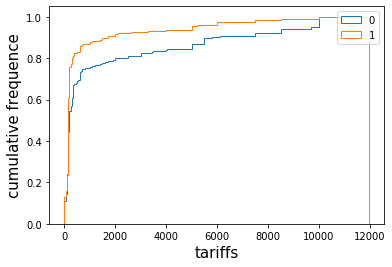

In [29]:
a.loc[a['label']==0]['amount_y'].dropna().plot.hist(bins=range(0,12000,50),histtype='step',label='0',normed=True,cumulative=True)
a.loc[df['label']==1]['amount_y'].dropna().plot.hist(bins=range(0,12000,50),histtype='step',label='1',normed=True,cumulative=True)
plt.legend(loc=1)
plt.xlabel('tariffs',size=15)
plt.ylabel('cumulative frequence',size=15)

In [30]:
df.columns

Index(['claim_id', 'enrollee_id', 'provider_id', 'provider_status', 'hmo_id',
       'care_id', 'qty', 'amount_x', 'approved_qty', 'approved_amount',
       'hmo_approved', 'created_at', 'vetted_at', 'label', 'unit_price', 'id',
       'diagnosis_id', 'amount_y'],
      dtype='object')

In [32]:
df.columns = ['claim_id', 'enrollee_id', 'provider_id', 'provider_status', 'hmo_id',
       'care_id', 'qty', 'amount', 'approved_qty', 'approved_amount',
       'hmo_approved', 'created_at', 'vetted_at', 'label', 'unit_price', 'id',
       'diagnosis_id', 'tariffs']

In [33]:
df[['claim_id', 'enrollee_id', 'provider_id', 'hmo_id','care_id', 'diagnosis_id','qty', 'amount',\
    'unit_price','tariffs', 'created_at', 'vetted_at', 'label']].to_csv('Processed_data/all_data.csv')
       
      
        